# 1.獲得関数の定義

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ncx2

def l2_lcb(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam = diff2 / gamma2
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    q = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    lower_bound = gamma2 * q
    return -lower_bound

def l2_ei(means, vars_, target, y_min, eps=1e-8):
    k = means.shape[1]
    gamma2 = np.maximum(vars_.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    nc = diff2 / gamma2
    x = y_min / gamma2
    t1 = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2 = gamma2 * (k * ncx2.cdf(x, df=k+2, nc=nc) + nc * ncx2.cdf(x, df=k+4, nc=nc))
    return np.maximum(0, t1 - t2)

# 補1 LCBの可視化

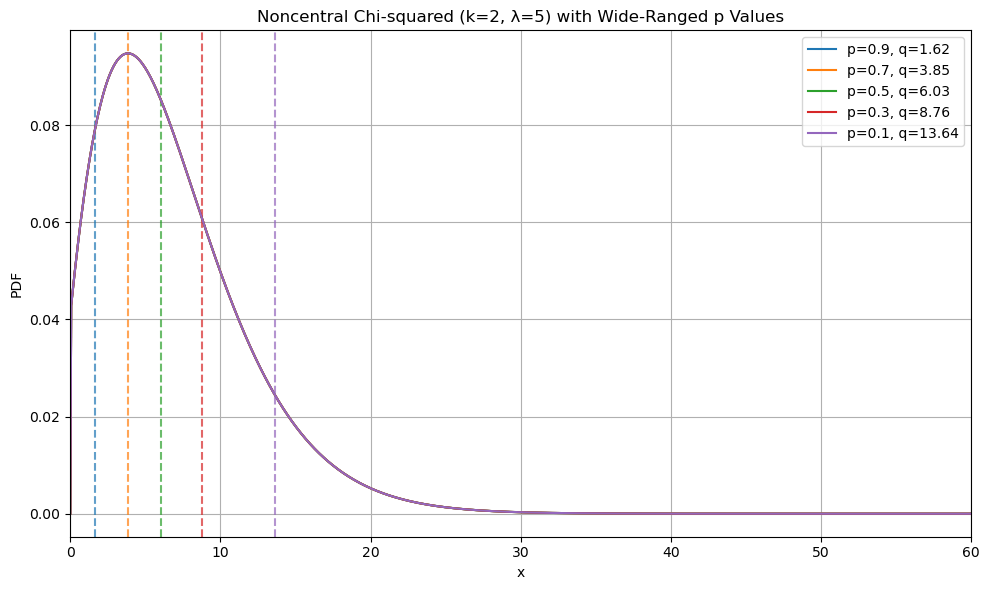

In [3]:
import matplotlib.pyplot as plt

# パラメータの設定
x_extended = np.linspace(0, 60, 1000)
wide_p_values = [0.9, 0.7, 0.5, 0.3, 0.1]
k = 2
lam = 5

# プロット作成
plt.figure(figsize=(10, 6))
for p in wide_p_values:
    pdf = ncx2.pdf(x_extended, df=k, nc=lam)
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    # プロットし、Line2D オブジェクトを取得
    line, = plt.plot(x_extended, pdf, label=f"p={p}, q={q:.2f}")
    # 線の色を取得して破線に適用
    plt.axvline(q, color=line.get_color(), linestyle='--', alpha=0.7)

plt.title("Noncentral Chi-squared (k=2, λ=5) with Wide-Ranged p Values")
plt.xlabel("x")
plt.ylabel("PDF")
plt.xlim(0, 60)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.dfの準備

In [2]:
input = "/Users/kaker/OneDrive - YNU(ynu.jp)/大学用/lab/VScode/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols = ["F12","F13","F14","F15","F16","F20","F0","R12","R13","R14","R15","R16","R20","R0"]
y_cols_m = ["mwave1", "msrength1"]
y_cols_d = ["dwave1", "dstrength1"]

# 3.網羅的探索関数の定義

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    q      = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=True)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=5)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_methods_gpy(df: pd.DataFrame,
                        X_cols: list,
                        Y_cols: list,
                        target: np.ndarray,
                        init_size: int,
                        trials: int = 100,
                        p: float = 0.05,
                        budget: int = None,
                        methods: list = ('lcb', 'ei', 'rand')):
    """
    Compare methods ('lcb','ei','rand') over multiple runs,
    ensuring that LCB and EI start from the same initial points each run.
    Returns:
      avg_dict: {method: mean cumulative hits array}
      history:  {method: array shape (trials, n_iter)}
      df_avg:   DataFrame of mean cumulative hits per iteration
    """
    N = len(df)
    if budget is None:
        n_iter = N - init_size
    else:
        n_iter = budget
    top_n = int(np.ceil(N * 0.05))

    # Precompute global distances and top indices
    scaler_global   = StandardScaler().fit(df[Y_cols].values)
    Y_scaled        = scaler_global.transform(df[Y_cols].values)
    target_scaled   = scaler_global.transform(target.reshape(1, -1)).flatten()
    dists           = np.linalg.norm(Y_scaled - target_scaled, axis=1)
    top_idx         = set(np.argsort(dists)[:top_n])

    history = {m: np.zeros((trials, n_iter), dtype=int) for m in methods}

    for run in range(trials):
        # fixed permutation for this run
        rng       = np.random.RandomState(run + 1)
        perm      = rng.permutation(N)
        train_base = list(perm[:init_size])
        cand_base  = list(perm[init_size:])

        for method in methods:
            # copy initial indices
            train_idx = train_base.copy()
            cand_idx  = cand_base.copy()
            cumulative = sum(i in top_idx for i in train_idx)

            # initial training data arrays
            X_train = df.iloc[train_idx][X_cols].values
            Y_train = df.iloc[train_idx][Y_cols].values

            # if using model-based method, fit initial GPs
            if method in ('lcb', 'ei'):
                scaler = StandardScaler().fit(Y_train)
                Y_train_s = scaler.transform(Y_train)
                models    = fit_multi_gpy(X_train, Y_train_s)
                target_s  = scaler.transform(target.reshape(1, -1)).flatten()

            for it in range(n_iter):
                X_cand = df.iloc[cand_idx][X_cols].values

                if method == 'lcb':
                    means, vars_ = predict_multi_gpy(models, X_cand)
                    scores       = l2_lcb_exact(means, vars_, target_s, p)
                    pick         = np.argmax(scores)

                elif method == 'ei':
                    means, vars_ = predict_multi_gpy(models, X_cand)
                    y_min        = np.min(np.sum((Y_train_s - target_s)**2, axis=1))
                    scores       = l2_ei(means, vars_, target_s, y_min)
                    pick         = np.argmax(scores)

                else:  # 'rand'
                    pick = rng.randint(len(cand_idx))

                chosen = cand_idx.pop(pick)
                if chosen in top_idx:
                    cumulative += 1
                history[method][run, it] = cumulative

                # update training data
                new_X = df.iloc[[chosen]][X_cols].values
                new_Y = df.iloc[[chosen]][Y_cols].values
                X_train = np.vstack([X_train, new_X])
                Y_train = np.vstack([Y_train, new_Y])

                if method in ('lcb', 'ei'):
                    scaler      = StandardScaler().fit(Y_train)
                    Y_train_s   = scaler.transform(Y_train)
                    target_s    = scaler.transform(target.reshape(1, -1)).flatten()
                    models      = fit_multi_gpy(X_train, Y_train_s)

    # compute averages
    avg_dict = {m: history[m].mean(axis=0) for m in methods}
    df_avg   = pd.DataFrame(avg_dict, index=np.arange(1, n_iter + 1))
    df_avg.index.name = 'iteration'
    return avg_dict, history, df_avg

def plot_comparison(df_avg: pd.DataFrame):
    plt.figure(figsize=(8, 5))
    for method in df_avg.columns:
        plt.plot(df_avg.index, df_avg[method], label=method.upper())
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Top 5% Hits")
    plt.title("GPy Search Method Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# avg_dict, history, df_avg = compare_methods_gpy(
#     df_all, X_cols, Y_cols, target,
#     init_size=5, trials=50, p=0.1, budget=200,
#     methods=['lcb','ei']
# )
# plot_comparison(df_avg)


# 4.網羅的探索の実行

Running for p = 0.70...


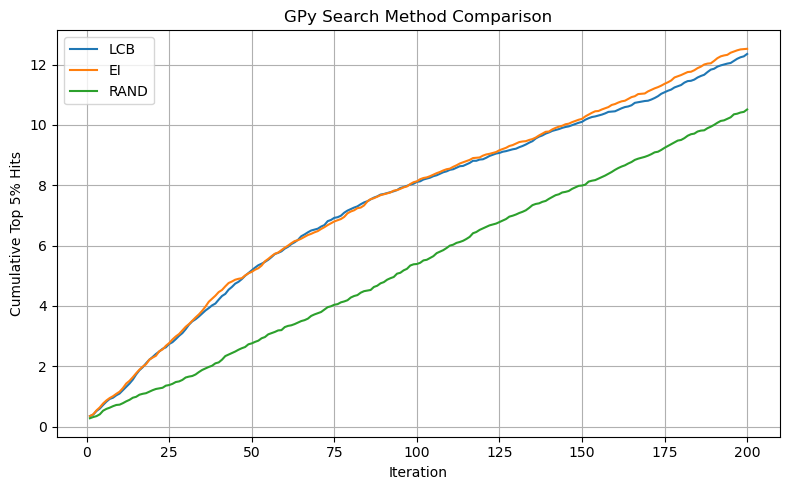

In [4]:
X_cols = ["F12","F13","F14","F15","F16","F20","F0",
              "R12","R13","R14","R15","R16","R20","R0"]
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])
p_candidates =[0.7]
# --- 比較実行 ---
for i in p_candidates:
    print(f"Running for p = {i:.2f}...")
    avg_counts, raw_hist,df_avg  = compare_methods_gpy(
        df_all, X_cols, Y_cols, target,
        init_size=5,
        trials=100,
        p=i,
        budget=200,
        methods=["lcb", "ei", "rand"]
    )

# --- 結果保存 & プロット ---
    df_avg.to_csv(f"avg_hits_p_{i:.2f}.csv", index=True)
    plot_comparison(df_avg)

# 5.EIによる探索(比較対象)

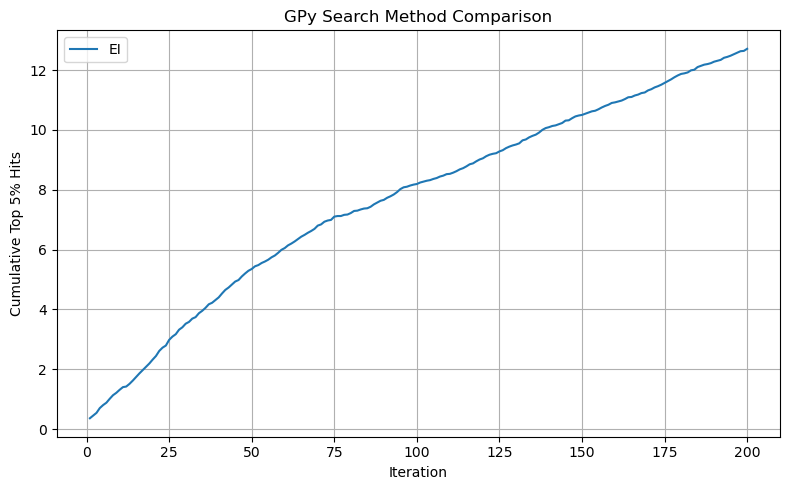

In [7]:
avg_counts, raw_hist, df_avg = compare_methods_gpy(
    df_all, X_cols, Y_cols, target,
    init_size=5,
    trials=100,
    p=0.05,
    budget=200,
    methods=["ei"]
)
df_avg.to_csv("avg_hits_p_0.05_ei.csv", index=True)
plot_comparison(df_avg)

# 6.グラフ復元

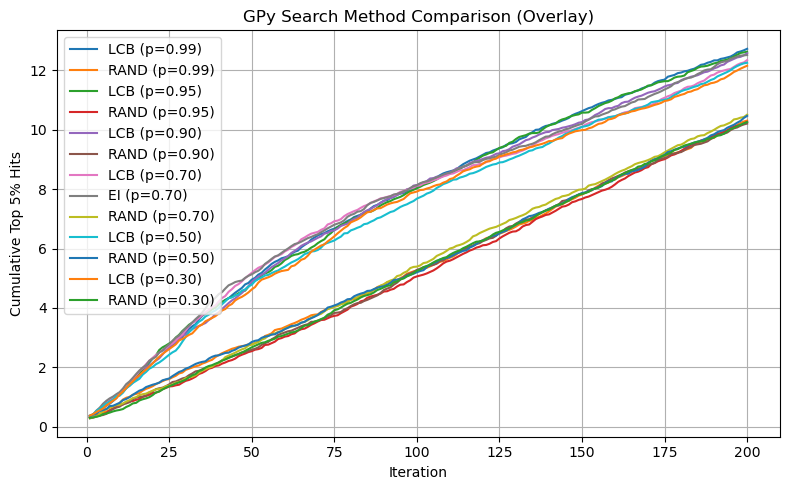

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_csvs(csv_paths, labels=None):
    """
    Overlay multiple CSVs of cumulative hit curves on a single plot.

    Parameters:
    - csv_paths: list of file paths to CSVs (each CSV has index=iteration, columns=methods)
    - labels: optional list of labels for each CSV (for legend). If None, filenames are used.
    """
    if labels is None:
        labels = [path for path in csv_paths]
    plt.figure(figsize=(8, 5))
    # Loop through each CSV file
    for path, label in zip(csv_paths, labels):
        df = pd.read_csv(path, index_col=0)
        for method in df.columns:
            plt.plot(df.index, df[method], label=f"{method.upper()} ({label})")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Top 5% Hits")
    plt.title("GPy Search Method Comparison (Overlay)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
csv_files = ["avg_hits_p_0.99.csv","avg_hits_p_0.95.csv", "avg_hits_p_0.90.csv","avg_hits_p_0.70.csv", "avg_hits_p_0.50.csv","avg_hits_p_0.30.csv"]
labels = ["p=0.99","p=0.95","p=0.90","p=0.70","p=0.50","p=0.30"]
plot_multiple_csvs(csv_files, labels)
